### Inference on target data

In [3]:
import easyocr.easyocr as easyocr
import cv2
import matplotlib.pyplot as plt
import glob
import os
from functools import partial
from multiprocessing.pool import Pool
import pandas as pd
import fastwer

/Users/alessa/miniconda3/envs/arabic-ocr/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
img_path1 = 'target_data/00a8d3f7-9097-454b-bdf3-b4449a817668-1048022238.jpeg'
img_path2 = 'target_data/0000ed05-b728-4b05-b5a6-0c3cde067f7a-1021537053hatmag2021-01-1a1.38.1.jpeg'
img_path3 = 'target_data/00c0ec3a-8828-4fa6-a8a6-9b2f682fa4cd-1012873335hatmag2022-03-0a12.23.21.jpeg'
img_path4 = 'target_data/00bf638a-8e29-42dc-9959-0caf00bba7eb-1029231790.jpeg'
lang_list = ['en', 'ar']

In [4]:
reader = easyocr.Reader(lang_list=lang_list)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [5]:
result = reader.readtext(img_path1)

In [6]:
result

[[[[296, 308], [396, 308], [396, 332], [296, 332]],
  '10/01/1959',
  0.9968164582605148],
 [[[441, 313], [523, 313], [523, 331], [441, 331]],
  '١٢٧٨١٠٧١٠',
  0.9306477124977379],
 [[[297, 338], [396, 338], [396, 366], [297, 366]],
  '16/11/2039',
  0.8340843049098199],
 [[[437, 346], [537, 346], [537, 366], [437, 366]],
  '٢٩ ٠ ١ ٤٦١ ١',
  0.5400432656298852],
 [[[439, 376], [534, 376], [534, 407], [439, 407]],
  'لها ادبالافلاج',
  0.4971184472251571]]

In [7]:
def extract_cords(preds):
    cords = []
    for pred in preds:
        x1, y1 = pred[0][0]
        x2, y2 = pred[0][2]
        cords.append([x1, y1, x2, y2])
    return cords

In [8]:
def display(img):
  fig = plt.figure(figsize=(5,4))
  ax = fig.add_subplot(111)
  new_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  ax.imshow(img)

In [9]:
def draw_rects(img, cords):
    for idx, cord in enumerate(cords):
        x1, y1, x2, y2 = cord
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
    return img

In [10]:
def pipeline(img_path, rotation_info=None):
    img = cv2.imread(img_path)
    result = reader.readtext(img, rotation_info=rotation_info)
    print(result)
    cords = extract_cords(result)
    img = draw_rects(img, cords)
    display(img)
    return [i[1] for i in result] # extracted test

[[[[296, 308], [396, 308], [396, 332], [296, 332]], '10/01/1959', 0.9968322071132523], [[[441, 313], [523, 313], [523, 331], [441, 331]], '١٢٧٨١٠٧١٠', 0.9306477124977379], [[[297, 338], [396, 338], [396, 366], [297, 366]], '16/11/2039', 0.8340843049098199], [[[437, 346], [537, 346], [537, 366], [437, 366]], '٢٩ ٠ ١ ٤٦١ ١', 0.5400432656298852], [[[439, 376], [534, 376], [534, 407], [439, 407]], 'لها ادبالافلاج', 0.49680533180759173]]


['10/01/1959', '١٢٧٨١٠٧١٠', '16/11/2039', '٢٩ ٠ ١ ٤٦١ ١', 'لها ادبالافلاج']

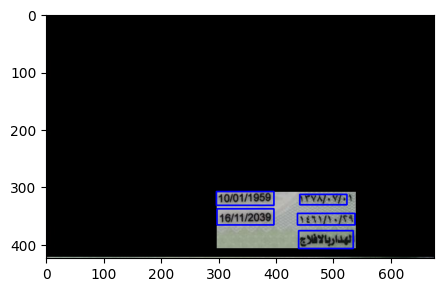

In [11]:
pipeline(img_path1)
# detection model missed the "١" & "/" charachters. 

[[[[153, 532], [232, 532], [232, 663], [153, 663]], '١٢', 0.17291675763804043], [[[103, 695], [237, 695], [237, 833], [103, 833]], 'بفًفقأًا', 0.00019902184046498582]]


['١٢', 'بفًفقأًا']

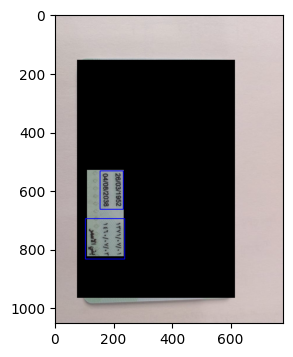

In [12]:
pipeline(img_path2)
# when orientation was wronge the detection model couldn't detect the text correctly
# this should be solved by predicting using diffrent orientation and selecting highest confiddence  

[[[[153, 532], [232, 532], [232, 663], [153, 663]], '28|03/2932', 0.344536232463915], [[[103, 695], [237, 695], [237, 833], [103, 833]], '٣', 0.2971564651490013]]


['28|03/2932', '٣']

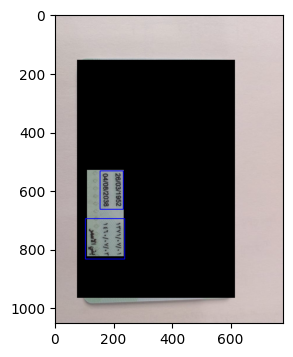

In [13]:
pipeline(img_path2, [90, 180 ,270]) # try rotating the image by these values 90, 180 ,270.
# much better, but still bad

[[[[608, 616], [716, 616], [716, 647], [608, 647]], '16/10/1966', 0.6193020885204539], [[[764, 614], [860, 614], [860, 638], [764, 638]], '٧١٠ ١٣٨٦/٠', 0.5983108724711569], [[[606, 651], [718, 651], [718, 684], [606, 684]], '28/08/2038', 0.7264620501788703], [[[763, 646], [876, 646], [876, 677], [763, 677]], '٠١٠٧١٢٧ ٤٦ ١', 0.3871639316107732]]


['16/10/1966', '٧١٠ ١٣٨٦/٠', '28/08/2038', '٠١٠٧١٢٧ ٤٦ ١']

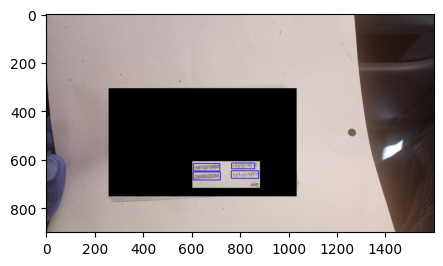

In [14]:
pipeline(img_path3)
# recognition model is having hard time predicting the charachter "١"

### Calculating WER & CER

##### Ground Truth Labels:-
Data has no ground truth labels, writing the labels from scratch can be time consuming, therefore, I will use the existing model predictions and correct the mistakes in order to save time.
Image with wronge orientation will be removed from the generated csv and get relabeled. For now, I will use the detection model as is, but I will re-annotate the recognition model predictions.

In [15]:
# for parallelization I implemented the function in a helper file
from helper import native_pipeline

In [16]:
# simple parallel function (not optimized), I didn't take into consideration any environment variables
# or queueing the processes.

# this function will generate a data folder containing the predictions of EasyOCR as well
# as a csv file containing the predicted labels of the target_data.

def prepare_data(root_dir, prepared_path):

    if not os.path.exists(prepared_path):
        os.mkdir(prepared_path)
    if not os.path.isfile('preds.csv'):
        df = pd.DataFrame(columns = ['filenames', 'words'])
        df.to_csv('preds.csv', index=False)
    
    paths = glob.glob(root_dir)

    f = partial(native_pipeline, prepared_path)

    with Pool(2) as p:
        p.map(f, paths)
        p.close()
        p.join()


In [ ]:
prepared_path = './prepared_data' # for saving the results
root_dir = './target_data/*' # source of reading the data, make sure directory ends with "/*"
prepare_data(root_dir, prepared_path)

# running this cell multiple times will cause an issue since I'm appending to the dataframe.

Empty box, can't save the image, Exception:  OpenCV(4.5.4) /private/var/folders/b7/g6qfbypj0tq32j5_trjh516r0000gn/T/pip-req-build-7s04pudm/opencv/modules/imgcodecs/src/loadsave.cpp:799: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

Empty box, can't save the image, Exception:  OpenCV(4.5.4) /private/var/folders/b7/g6qfbypj0tq32j5_trjh516r0000gn/T/pip-req-build-7s04pudm/opencv/modules/imgcodecs/src/loadsave.cpp:799: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

Empty box, can't save the image, Exception:  OpenCV(4.5.4) /private/var/folders/b7/g6qfbypj0tq32j5_trjh516r0000gn/T/pip-req-build-7s04pudm/opencv/modules/imgcodecs/src/loadsave.cpp:799: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



In [5]:
# I need to sort the values of the preds.csv for easier annotation
df = pd.read_csv('preds.csv')

In [6]:
df.head(2)

,filenames,words
0,0_00a99c88-2544-4d31-8af4-8169c120fe2d-1048665...,13/09/1989
1,1_00a99c88-2544-4d31-8af4-8169c120fe2d-1048665...,١٢٨٩١٠٧١٠


In [7]:
## copied // I might reimplement this using pandas method: df.str.extract method if I have more time.
import re
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [8]:
len(os.listdir('prepared_data'))

318

In [9]:
sorted = sorted_alphanumeric(os.listdir('prepared_data'))

In [10]:
df_sorted = pd.DataFrame({'filenames':sorted})
df_sorted

,filenames
0,0_00a8d3f7-9097-454b-bdf3-b4449a817668-1048022...
1,0_00a8d7b2-fc7b-4836-8710-46aae42caa25-1024679...
2,0_00a9b89b-87d3-42a2-8cdf-6ecf7b21fb8a-1051301...
3,0_00a9ef02-adee-4664-a4d8-04ef4cf56728-1027564...
4,0_00a99c88-2544-4d31-8af4-8169c120fe2d-1048665...
...,...
313,25_Reference 05.png
314,26_Reference 05.png
315,27_Reference 05.png
316,28_Reference 05.png


In [11]:
df_prepared = df_sorted.join(df.set_index('filenames'), on='filenames')

In [13]:
df_prepared.to_csv('for_annotation.csv', index=False)

After annotation I named the file "ground_truth.csv"

In [14]:
ground_truth = pd.read_csv('ground_truth.csv')
ground_truth = ground_truth.rename(columns={"words": "label"})
preds = pd.read_csv('preds.csv')
preds = preds.rename(columns={"words": "preds"})

In [15]:
preds.head(2)

,filenames,preds
0,0_00a99c88-2544-4d31-8af4-8169c120fe2d-1048665...,13/09/1989
1,1_00a99c88-2544-4d31-8af4-8169c120fe2d-1048665...,١٢٨٩١٠٧١٠


In [16]:
ground_truth.head(2)

,filenames,label,type
0,0_0000cbb7-01aa-4b70-90a6-5f0cb8b36cdd-1020721...,20/01/1958,en_date
1,0_0000e413-8900-48b7-bb95-305b913739b5-1005052...,##,##


In [17]:
df = preds.sort_values('filenames').join(ground_truth.set_index('filenames'), on='filenames')

In [18]:
df = df.dropna()

In [19]:
df.head(2)

,filenames,preds,label,type
122,0_0000cbb7-01aa-4b70-90a6-5f0cb8b36cdd-1020721...,20/01/1958,20/01/1958,en_date
273,0_0000e413-8900-48b7-bb95-305b913739b5-1005052...,؛؟,##,##


In [20]:
# drop unreadable images "#" and rotated images "##"
df = df[(df['label'] != '##') & (df['label'] != '##')]

In [21]:
df.head(2)

,filenames,preds,label,type
122,0_0000cbb7-01aa-4b70-90a6-5f0cb8b36cdd-1020721...,20/01/1958,20/01/1958,en_date
65,0_00a8d3f7-9097-454b-bdf3-b4449a817668-1048022...,10/01/1959,10/01/1959,en_date


In [22]:
df["CER"] = df.apply(lambda x: fastwer.score_sent(x["preds"], x["label"], char_level=True), axis = 1)
df["WER"] = df.apply(lambda x: fastwer.score_sent(x["preds"], x["label"], char_level=False), axis = 1)

In [23]:
df.head(2)

,filenames,preds,label,type,CER,WER
122,0_0000cbb7-01aa-4b70-90a6-5f0cb8b36cdd-1020721...,20/01/1958,20/01/1958,en_date,0.0,0.0
65,0_00a8d3f7-9097-454b-bdf3-b4449a817668-1048022...,10/01/1959,10/01/1959,en_date,0.0,0.0


In [24]:
## Overall WER & CER
print('WER: ', df['WER'].mean())
print('CER: ', df['CER'].mean())

WER:  97.32868745644599
CER:  31.491260627177706


### Inference Results

In [ ]:
## WER per type
print('en_date WER: ', df.WER[df.type == 'en_date'].mean(), ', No. Samples: ', len(df.WER[df.type == 'en_date']))
print('ar_date WER: ', df.WER[df.type == 'ar_date'].mean(), ', No. Samples: ', len(df.WER[df.type == 'ar_date']))
print('en_text WER: ', df.WER[df.type == 'en_text'].mean(), ', No. Samples: ', len(df.WER[df.type == 'en_text']))
print('ar_text WER: ', df.WER[df.type == 'ar_text'].mean(), ', No. Samples: ', len(df.WER[df.type == 'ar_text']))
## CER per type
print('en_date CER: ', df.CER[df.type == 'en_date'].mean(), ', No. Samples: ', len(df.CER[df.type == 'en_date']))
print('ar_date CER: ', df.CER[df.type == 'ar_date'].mean(), ', No. Samples: ', len(df.CER[df.type == 'ar_date']))
print('en_text CER: ', df.CER[df.type == 'en_text'].mean(), ', No. Samples: ', len(df.CER[df.type == 'en_text']))
print('ar_text CER: ', df.CER[df.type == 'ar_text'].mean(), ', No. Samples: ', len(df.CER[df.type == 'ar_text']))

en_date WER:  8.562690825688074 , No. Samples:  109
ar_date WER:  213.20754716981133 , No. Samples:  106
en_text WER:  112.5 , No. Samples:  8
ar_text WER:  53.96825396825397 , No. Samples:  63
en_date CER:  3.4174311926605503 , No. Samples:  109
ar_date CER:  51.49203773584905 , No. Samples:  106
en_text CER:  107.0833375 , No. Samples:  8
ar_text CER:  15.089985714285715 , No. Samples:  63


### Runing Overfitted model

You have to do this manually, move/copy the model from EasyOCR/models to home/XXXX/.EasyOCR/model/
If you don't have this directory, run the cell below to download their model and create the directory for you then replace the models.

In [ ]:
reader2 = easyocr.Reader(lang_list=lang_list, download_enabled=False, gpu=True) # overfitted on wrong label to assure if it works or not

In [4]:
img_test = './trainer/all_data/ar_train/0.png'
result = reader2.readtext(img_test)

In [5]:
result[0][1] # the output should be '١١٤٠/٠٨/٠٩١'

'٠١'